### Libraries

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import re
from math import log
import csv
import matplotlib.dates as mdates
import seaborn as sns

# Metric: Transaction Response Times (TRT) in ms

## Formatting

#### CSV

In [34]:
def process_file_data_to_csv(filename):

    timestamps = []
    data_rows = []

    storedprocs = ["neword", "payment", "delivery", "slev", "ostat"]

    with open(filename, "r") as file:
        for line in file:
            # Extract time intervals
            if "PERCENTILES" in line:
                timestamp = line.split()[3]
                if timestamp not in timestamps:
                    timestamps.append(timestamp)

            for storedproc in storedprocs:
                if f"|{storedproc}|" in line.lower():
                    min_val = re.search(r"MIN-([0-9.]+)", line).group(1)
                    p50_val = re.search(r"P50%-([0-9.]+)", line).group(1)
                    p95_val = re.search(r"P95%-([0-9.]+)", line).group(1)
                    p99_val = re.search(r"P99%-([0-9.]+)", line).group(1)
                    max_val = re.search(r"MAX-([0-9.]+)", line).group(1)

                    data_rows.append(
                        {
                            "Timestamp": timestamp,
                            "Transaction_Type": storedproc.upper(),
                            "MIN": min_val,
                            "P50%": p50_val,
                            "P95%": p95_val,
                            "P99%": p99_val,
                            "MAX": max_val,
                        }
                    )

    df = pd.DataFrame(data_rows)

    output_filename = filename.replace(".log", ".csv")
    df.to_csv(output_filename, index=False)

    print(f"Processed data has been saved to {output_filename}")


# Sample filename usage
filename = "TRT/filtered_transaction_data.log"
process_file_data_to_csv(filename)

Processed data has been saved to TRT/filtered_transaction_data.csv


## Preprocessing 

#### NEWORD P50% Percentile in ms on logarithmic scale

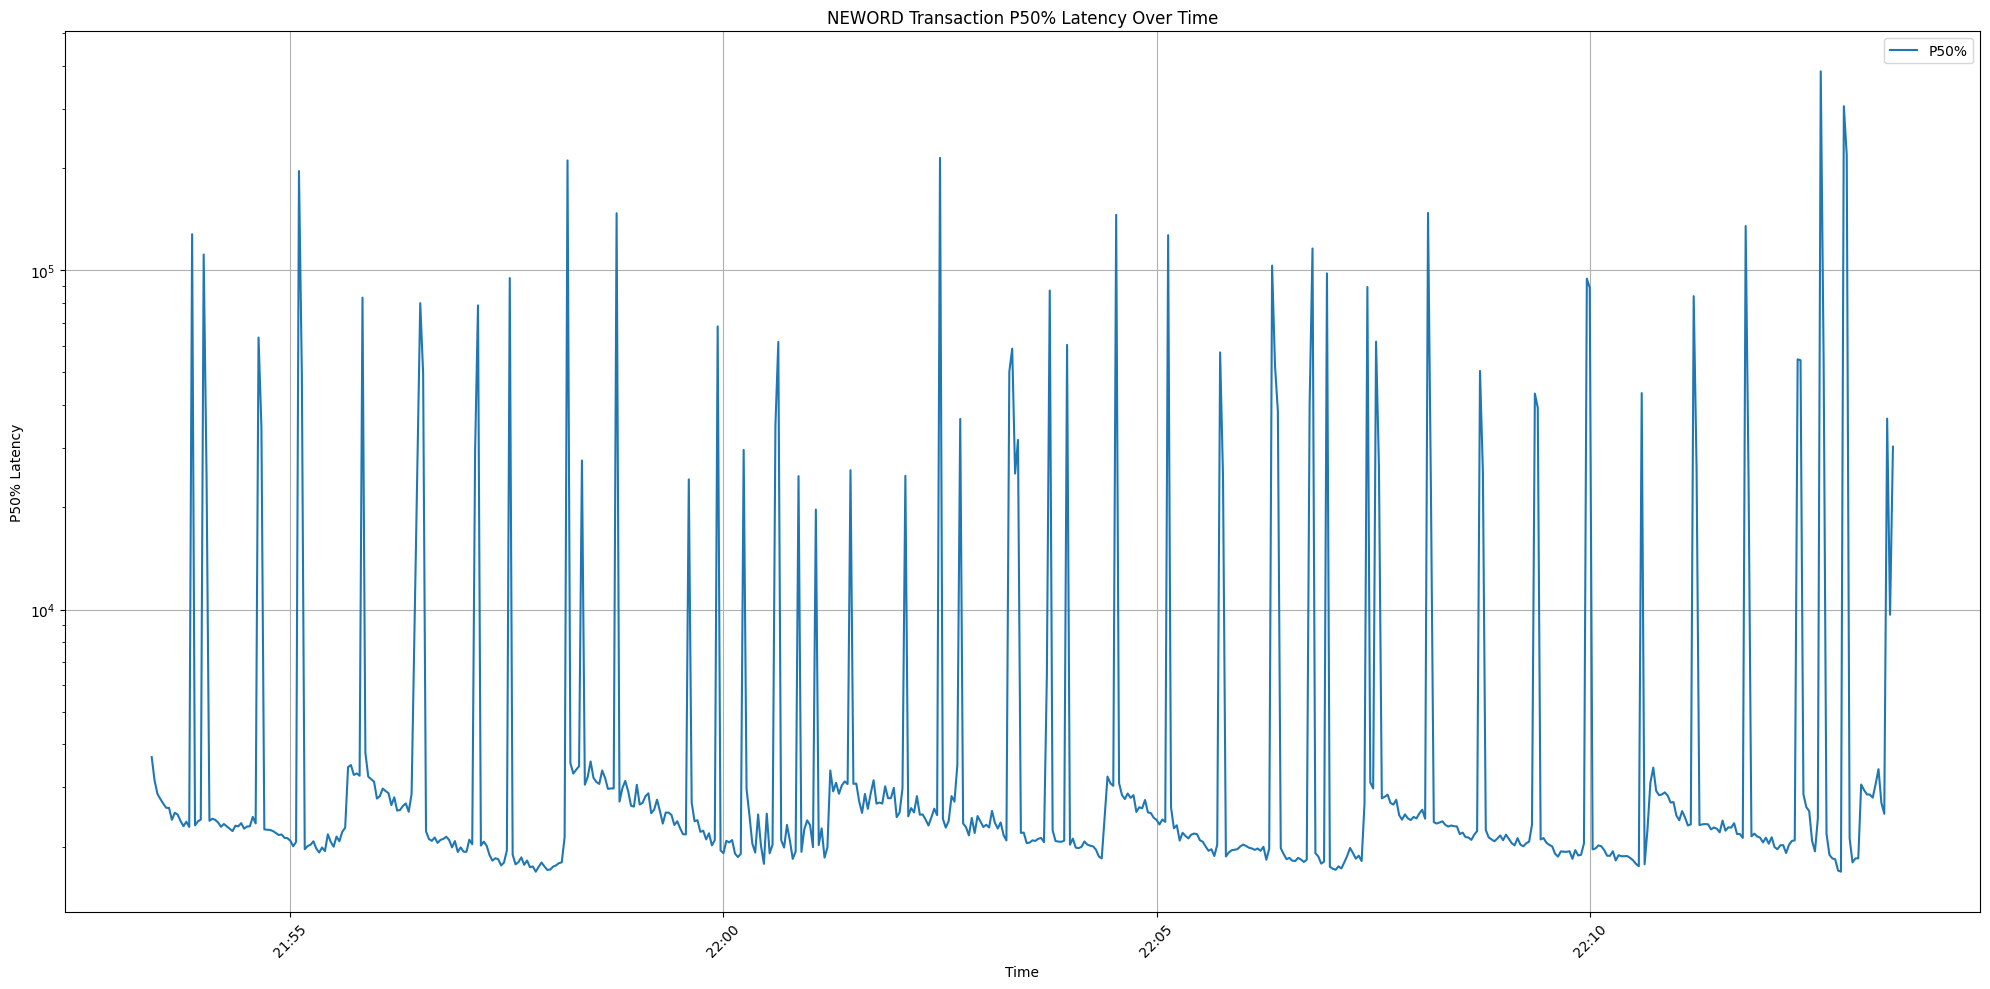

In [42]:
trt_df = pd.read_csv('TRT/filtered_transaction_data.csv')
neword_df = trt_df[trt_df['Transaction_Type'] == 'NEWORD'].copy()
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

plt.figure(figsize=(20, 10))

plt.plot(
    neword_df["Timestamp"], neword_df["P50%"], label="P50%", linestyle="-"
)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

plt.xlabel("Time")
plt.ylabel("P50% Latency")
plt.title("NEWORD Transaction P50% Latency Over Time")

plt.grid(True)

plt.yscale('log')
plt.tight_layout()

plt.legend()

plt.show()

#### NEWORD P50% Percentile in ms 

In [ ]:
trt_df = pd.read_csv("TRT/filtered_transaction_data.csv")
neword_df = trt_df[trt_df["Transaction_Type"] == "NEWORD"].copy()
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

plt.figure(figsize=(20, 10))

plt.plot(neword_df["Timestamp"], neword_df["P50%"], label="P50%", linestyle="-")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

plt.xlabel("Time")
plt.ylabel("P50% Latency")
plt.title("NEWORD Transaction P50% Latency Over Time")

plt.grid(True)

plt.tight_layout()

plt.legend()

plt.show()

#### NEWORD P95% Percentile in ms

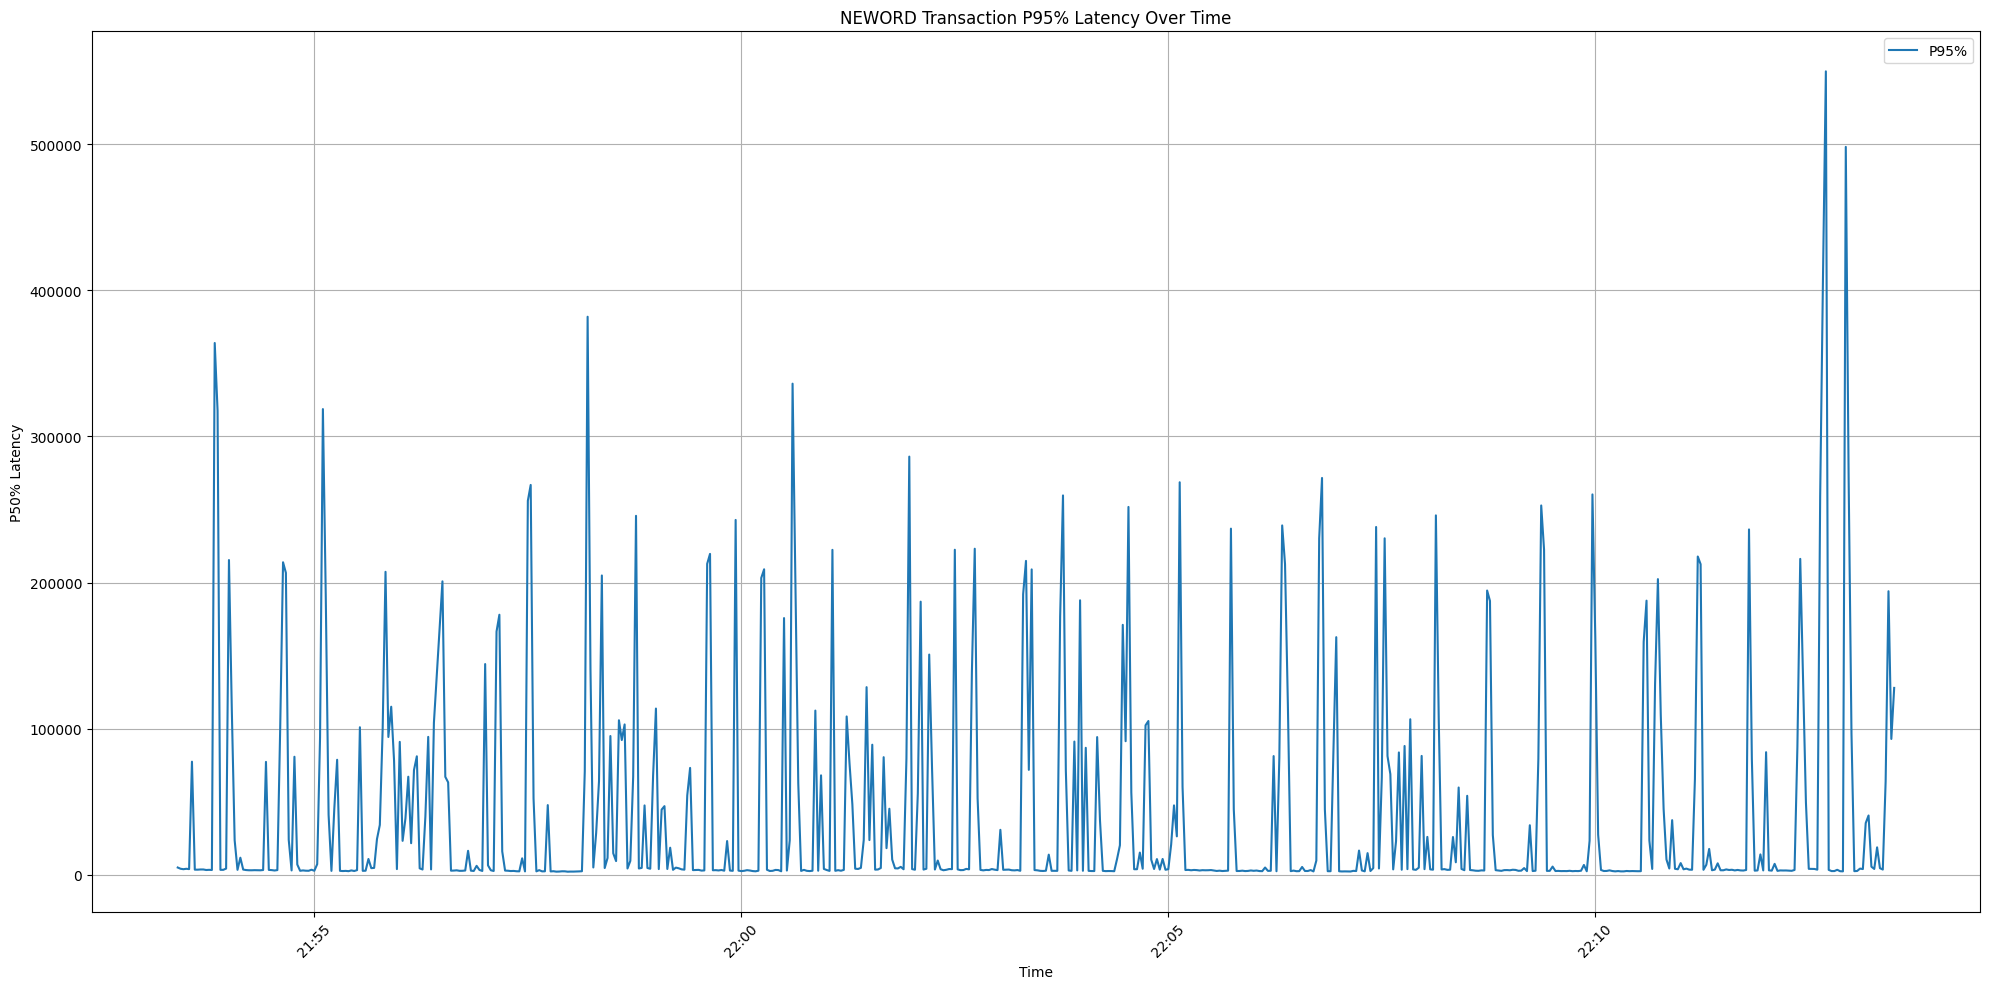

In [44]:
trt_df = pd.read_csv("TRT/filtered_transaction_data.csv")
neword_df = trt_df[trt_df["Transaction_Type"] == "NEWORD"].copy()
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

plt.figure(figsize=(20, 10))

plt.plot(neword_df["Timestamp"], neword_df["P95%"], label="P95%", linestyle="-")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

plt.xlabel("Time")
plt.ylabel("P50% Latency")
plt.title("NEWORD Transaction P95% Latency Over Time")

plt.grid(True)

plt.tight_layout()

plt.legend()

plt.show()

#### NEWORD P95% Percentile in ms on logarithmic scale

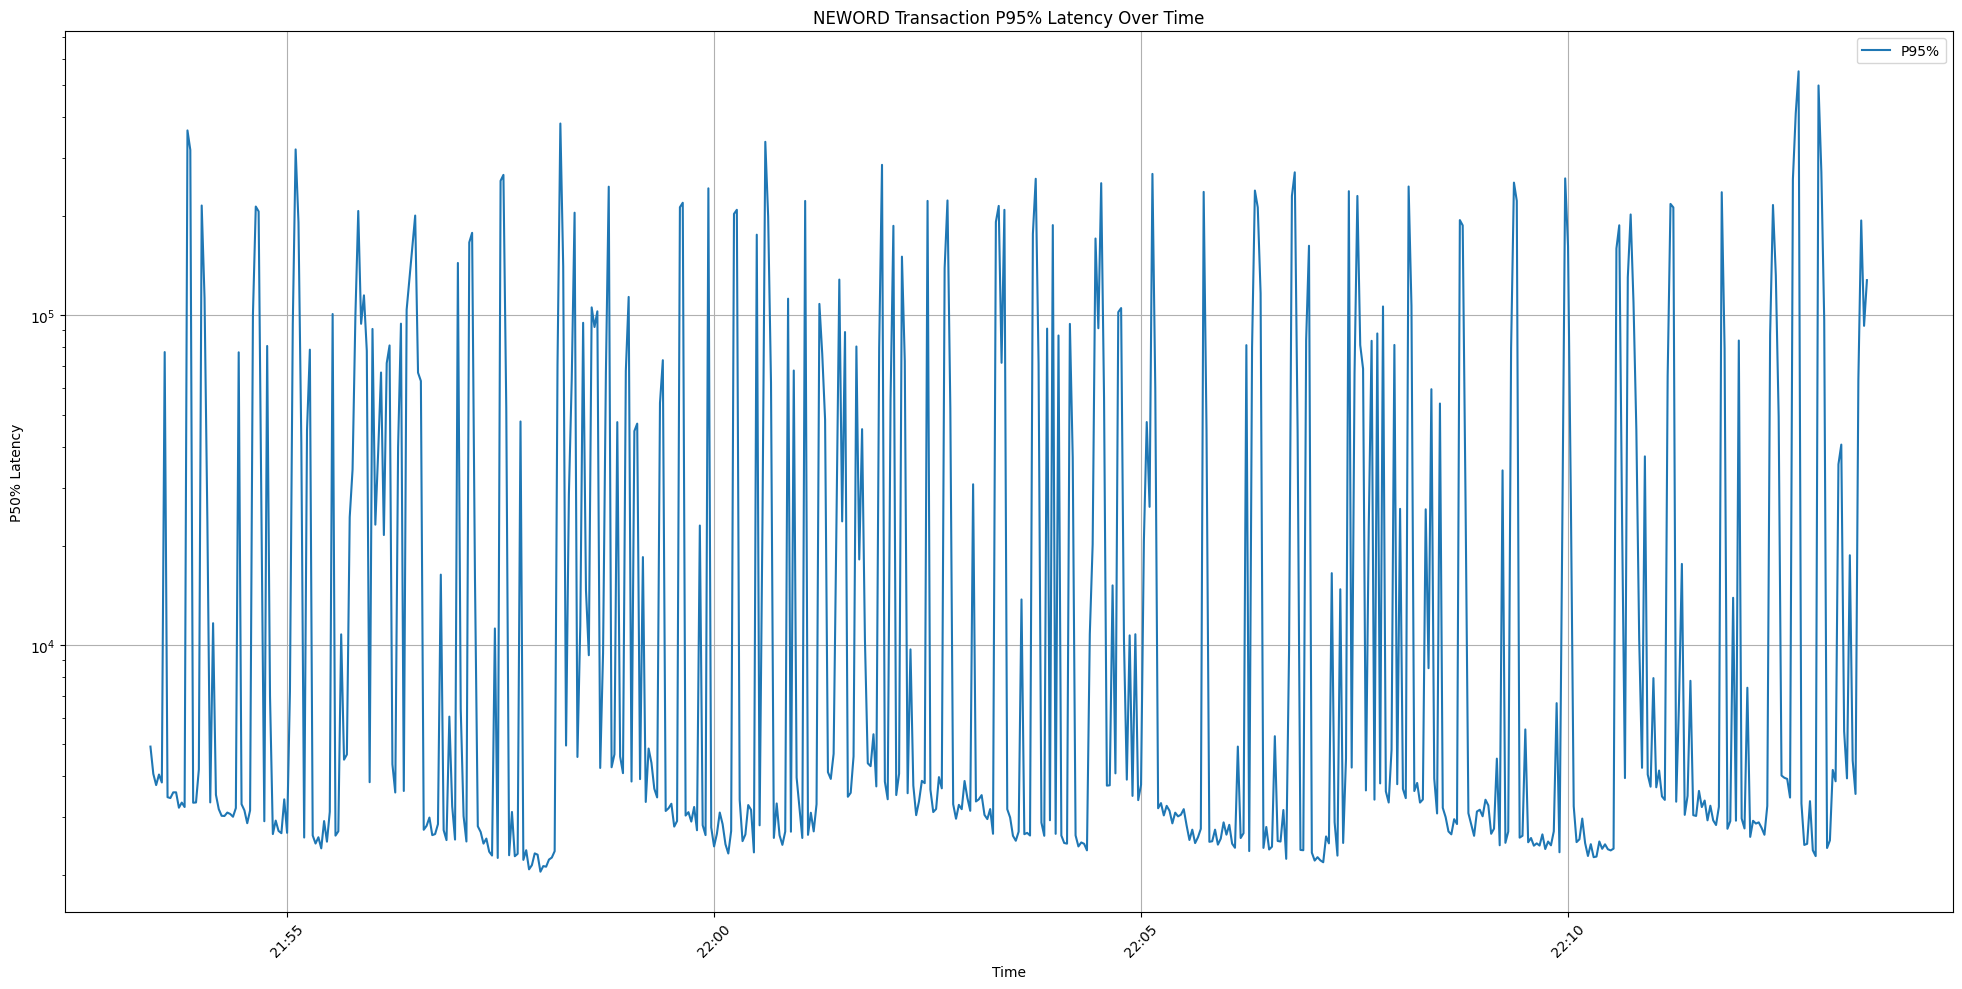

In [46]:
trt_df = pd.read_csv("TRT/filtered_transaction_data.csv")
neword_df = trt_df[trt_df["Transaction_Type"] == "NEWORD"].copy()
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

plt.figure(figsize=(20, 10))

plt.plot(neword_df["Timestamp"], neword_df["P95%"], label="P95%", linestyle="-")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

plt.xlabel("Time")
plt.ylabel("P50% Latency")
plt.title("NEWORD Transaction P95% Latency Over Time")

plt.grid(True)

plt.tight_layout()

plt.yscale('log')

plt.legend()

plt.show()

## Statistical Analysis (only done for Metric: TRT (ms))

#### Slicing of time-series at known change points

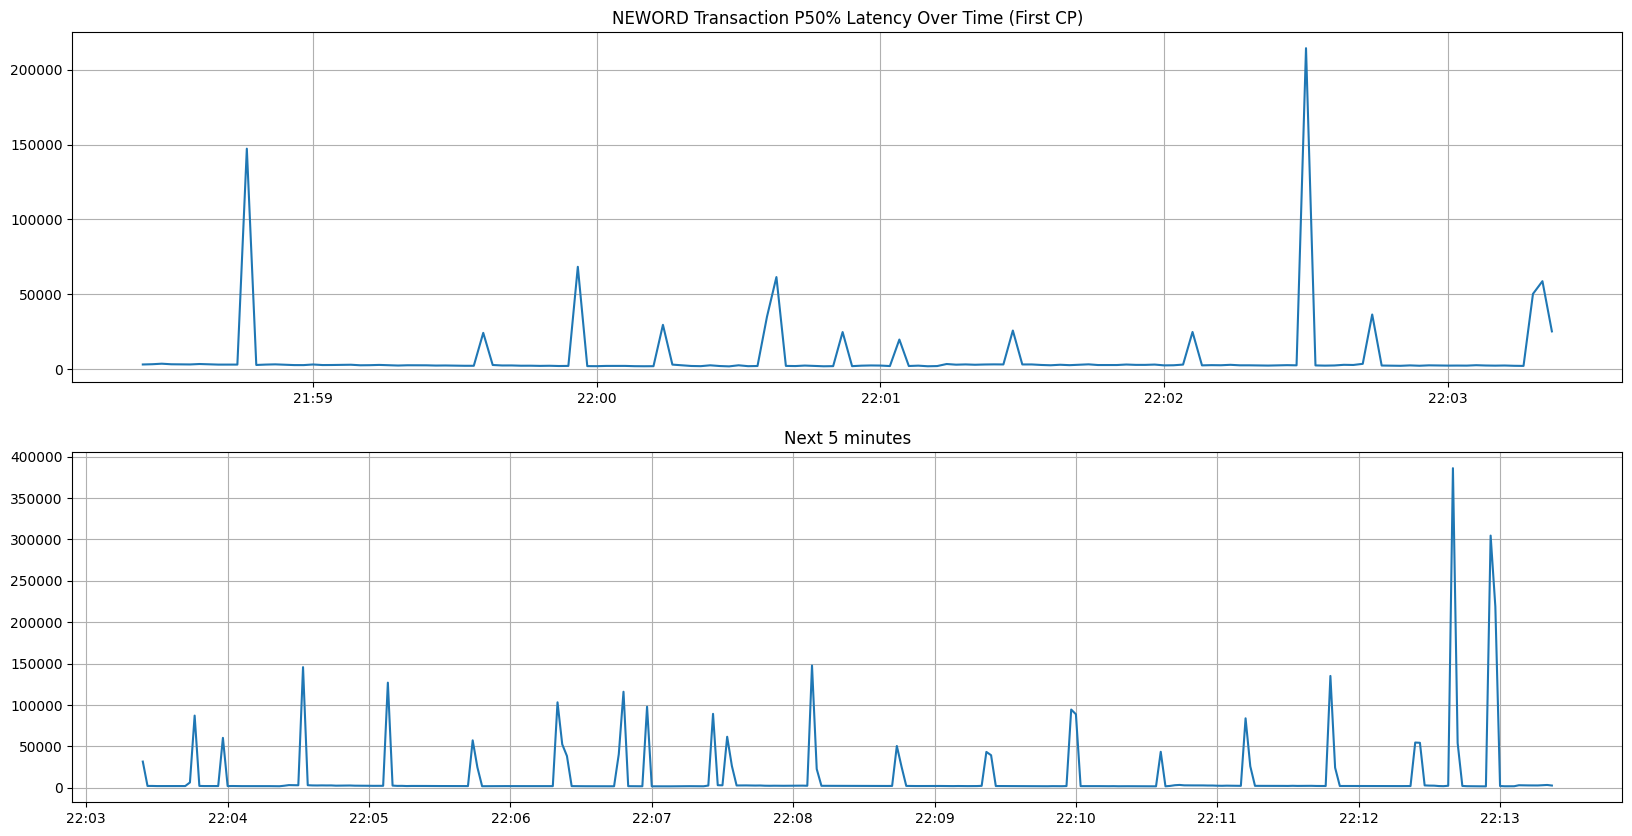

In [51]:
start_time = neword_df["Timestamp"].min()

df_firstCP = neword_df[(neword_df["Timestamp"] >= start_time + pd.Timedelta(minutes=5)) & (neword_df["Timestamp"] < start_time + pd.Timedelta(minutes=10))]
df_2ndCP = neword_df[(neword_df["Timestamp"] >= start_time + pd.Timedelta(minutes=10)) & (neword_df["Timestamp"] < start_time + pd.Timedelta(minutes=20))]

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# First Subplot
axs[0].plot(df_firstCP["Timestamp"], df_firstCP["P50%"], label="P50%", linestyle="-")
axs[0].set_title("NEWORD Transaction P50% Latency Over Time (First CP)")
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[0].grid(True)

# Second Subplot
axs[1].plot(df_2ndCP["Timestamp"], df_2ndCP["P50%"], label="P50%", linestyle="-")
axs[1].set_title("Next 5 minutes")
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].grid(True)



#### Calculating mean, variance and standard deviation of time-series before and after change points 

Text(0.02, 0.95, 'Mean: 12147.64\nVariance: 1456098186.10\nStd Dev: 38158.85')

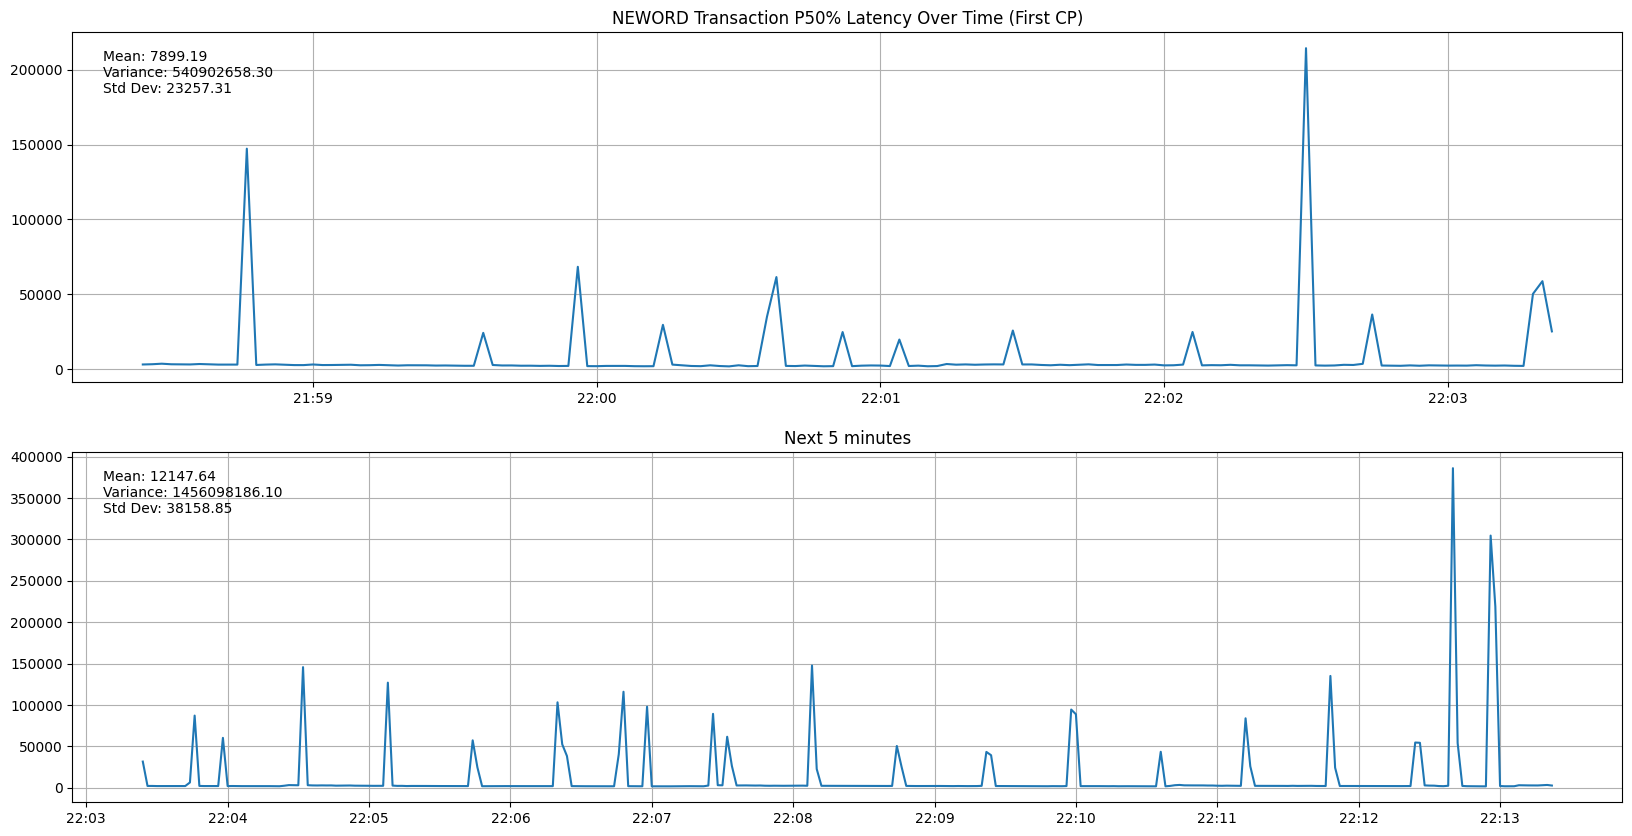

In [53]:
start_time = neword_df["Timestamp"].min()

df_firstCP = neword_df[
    (neword_df["Timestamp"] >= start_time + pd.Timedelta(minutes=5))
    & (neword_df["Timestamp"] < start_time + pd.Timedelta(minutes=10))
]
df_2ndCP = neword_df[
    (neword_df["Timestamp"] >= start_time + pd.Timedelta(minutes=10))
    & (neword_df["Timestamp"] < start_time + pd.Timedelta(minutes=20))
]

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# First Subplot
axs[0].plot(df_firstCP["Timestamp"], df_firstCP["P50%"], label="P50%", linestyle="-")
axs[0].set_title("NEWORD Transaction P50% Latency Over Time (First CP)")
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[0].grid(True)

# Stats 1
mean = df_firstCP["P50%"].mean()
variance = df_firstCP["P50%"].var()
std_dev = df_firstCP["P50%"].std()
axs[0].text(0.02, 0.95, f'Mean: {mean:.2f}\nVariance: {variance:.2f}\nStd Dev: {std_dev:.2f}', transform=axs[0].transAxes, verticalalignment='top')


# Second Subplot
axs[1].plot(df_2ndCP["Timestamp"], df_2ndCP["P50%"], label="P50%", linestyle="-")
axs[1].set_title("Next 5 minutes")
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].grid(True)

# Stats 2
mean = df_2ndCP["P50%"].mean()
variance = df_2ndCP["P50%"].var()
std_dev = df_2ndCP["P50%"].std()
axs[1].text(0.02, 0.95, f'Mean: {mean:.2f}\nVariance: {variance:.2f}\nStd Dev: {std_dev:.2f}', transform=axs[1].transAxes, verticalalignment='top')


## CPD

#### PELT

In [ ]:
trt_df = pd.read_csv("TRT/filtered_transaction_data.csv")
neword_df = trt_df[trt_df["Transaction_Type"] == "NEWORD"].copy()
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

# Modeling
signal = neword_df["P50%"].values

model = "l2"  # "l1", "rbf" # Try with different models and compare results

algo = rpt.Pelt(model=model).fit(signal)   

result = algo.predict(pen=100)

# Using ruptures display function
rpt.display(signal, result, figsize=(10, 6))
plt.title("Change Points detected by Pelt Algorithm")
plt.show()

#### DP (with know and unknown change points passed as argument)

In [ ]:
trt_df = pd.read_csv("TRT/filtered_transaction_data.csv")
neword_df = trt_df[trt_df["Transaction_Type"] == "NEWORD"].copy()
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

# Modeling
signal = neword_df["P50%"].values
model = "l2"  # euclidean distance
algo = rpt.Dynp(model=model, min_size=1, jump=5).fit(signal)
result = algo.predict(n_bkps=2)

rpt.display(signal, result, figsize=(10, 6))
plt.title("Change Points detected by DP Algorithm with known CPs")
plt.show()

# Metric: SYS-resources (CPU & memory)

## PreProcessing

#### CPU usage (%) on logarithmic scale

In [ ]:
df = pd.read_csv("SYS/docker_container_stats.csv")

df.columns = df.columns.str.strip()

df['CPU Usage (%)'] = df['CPU Usage (%)'].str.rstrip('%')
df['Time'] = pd.to_datetime(df['Time'])

cpu_df = df[['Time', 'CPU Usage (%)']].copy()

# print(cpu_df.head(5))

plt.figure(figsize=(25, 10))

plt.plot(cpu_df["Time"], cpu_df["CPU Usage (%)"], linestyle="-", label="CPU Usage (%)")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

plt.xlabel("Time in ms")
plt.ylabel("CPU Usage (%)")
plt.title("CPU Usage in (%) over Time")

# plt.grid(True)
plt.yscale("log")

plt.tight_layout()

plt.legend()

plt.show()

#### Memory usage (%)

                 Time Memory Usage (%)
0 2024-03-08 21:53:31             1.74
1 2024-03-08 21:53:34             1.82
2 2024-03-08 21:53:38             1.87
3 2024-03-08 21:53:41             1.90
4 2024-03-08 21:53:45             1.93


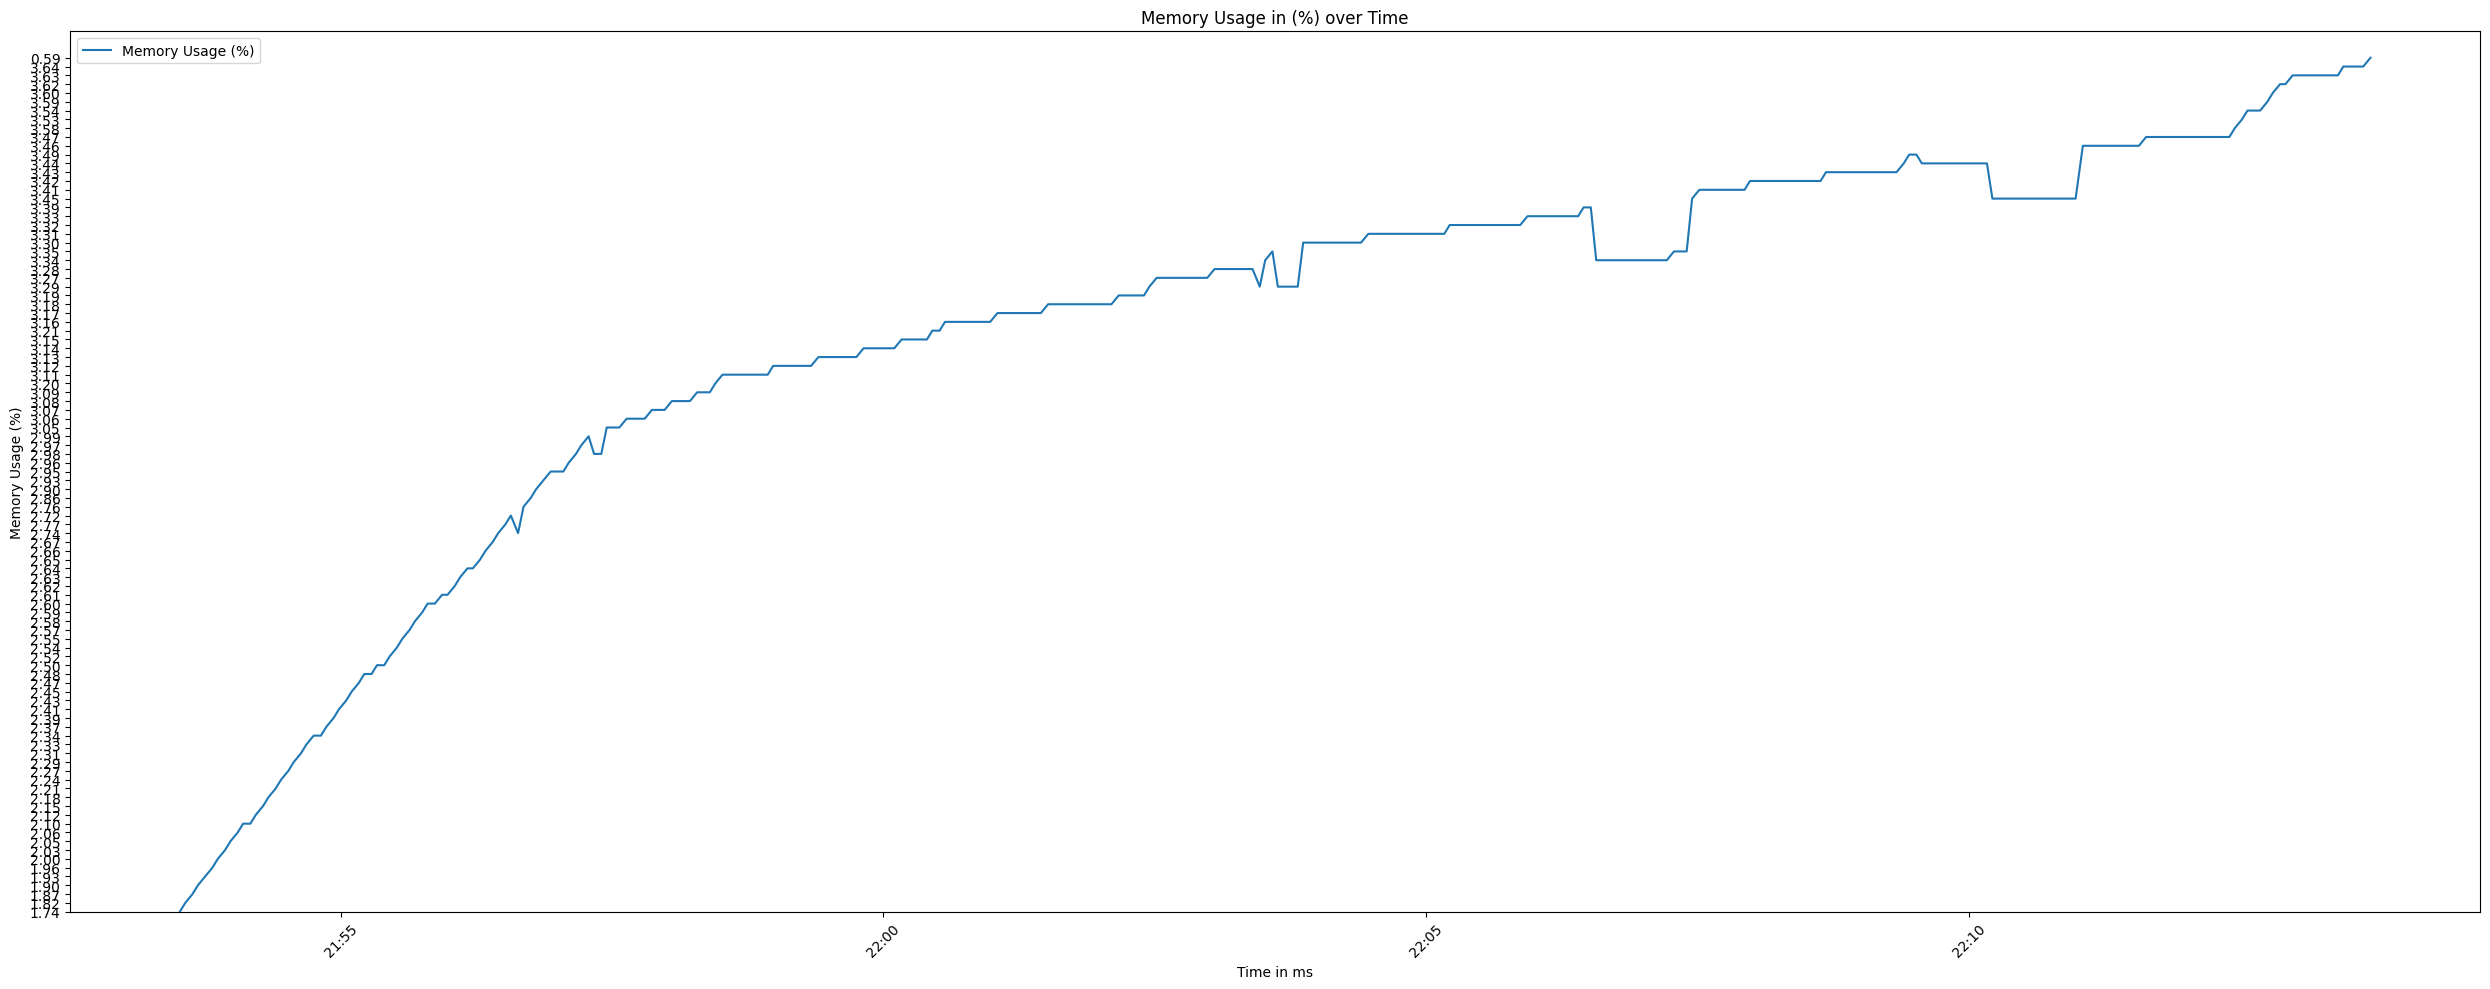

In [113]:
df = pd.read_csv("SYS/docker_container_stats.csv")

df.columns = df.columns.str.strip()

df['Memory Usage (%)'] = df['Memory Usage (%)'].str.rstrip("%")
df["Time"] = pd.to_datetime(df["Time"])

mem_df = df[['Time', 'Memory Usage (%)']].copy()

print(mem_df.head(5))


# print(cpu_df.head(5))


plt.figure(figsize=(25, 10))

plt.plot(mem_df["Time"], mem_df["Memory Usage (%)"], linestyle="-", label="Memory Usage (%)")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

plt.xlabel("Time in ms")
plt.ylabel("Memory Usage (%)")
plt.title("Memory Usage in (%) over Time")

# plt.grid(True)
#plt.yscale("log")
plt.ylim(0, 100)
plt.tight_layout()
plt.legend()

plt.show()

## CPD

#### PELT for memory usage

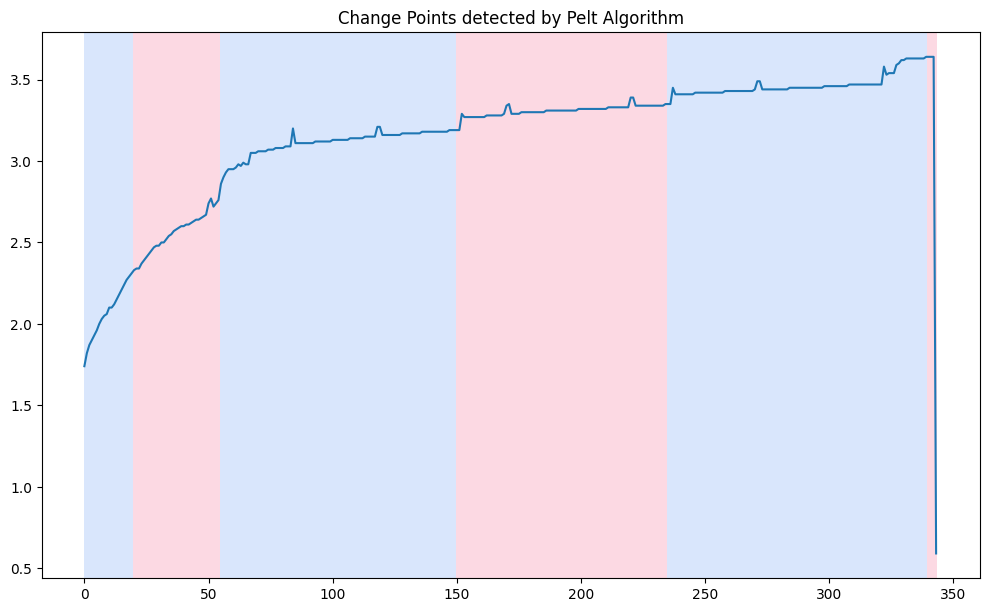

In [135]:
mem_df["Memory Usage (%)"] = mem_df["Memory Usage (%)"].astype(str).str.rstrip("%")

mem_df["Memory Usage (%)"] = mem_df["Memory Usage (%)"].astype("float")

signal = mem_df["Memory Usage (%)"].values

model = "l2"  # "l1", "rbf" # Try with different models and compare results

algo = rpt.Pelt(model=model).fit(signal)

result = algo.predict(pen=1)

# Using ruptures display function
rpt.display(signal, result, figsize=(10, 6))
plt.title("Change Points detected by Pelt Algorithm")
plt.show()

#### Pelt for cpu usage

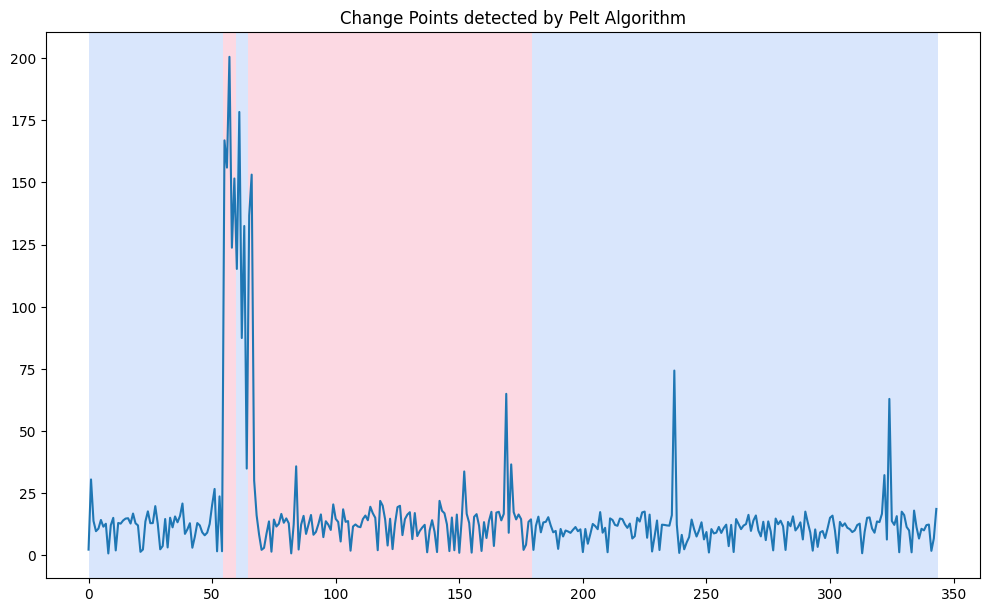

In [208]:
cpu_df["CPU Usage (%)"] = cpu_df["CPU Usage (%)"].astype(str).str.rstrip("%")

cpu_df["CPU Usage (%)"] = (cpu_df["CPU Usage (%)"].astype(str).str.rstrip("% ").astype("float"))

signal = cpu_df["CPU Usage (%)"].values

model = "l1"  # "l1", "rbf" # Try with different models and compare results

algo = rpt.Pelt(model=model).fit(signal)

result = algo.predict(pen=25)

# Using ruptures display function
rpt.display(signal, result, figsize=(10, 6))
plt.title("Change Points detected by Pelt Algorithm")
plt.show()

#### DP for memory usage

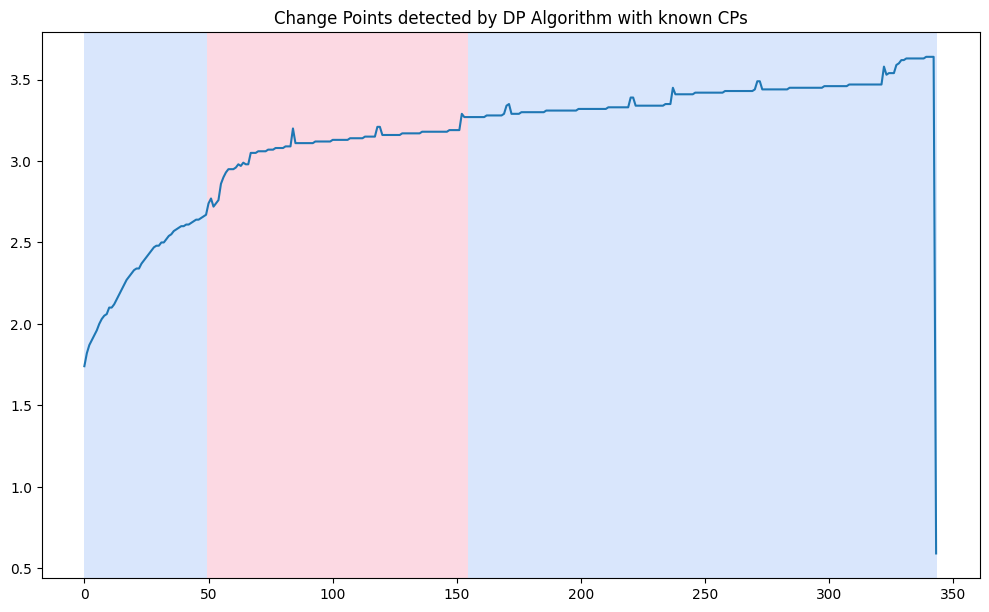

In [143]:
mem_df["Memory Usage (%)"] = mem_df["Memory Usage (%)"].astype(str).str.rstrip("%")

mem_df["Memory Usage (%)"] = mem_df["Memory Usage (%)"].astype("float")

signal = mem_df["Memory Usage (%)"].values

model = "l2"  # "l1", "rbf" # Try with different models and compare results

algo = rpt.Dynp(model=model, min_size=1, jump=5).fit(signal)
result = algo.predict(n_bkps=2)

rpt.display(signal, result, figsize=(10, 6))
plt.title("Change Points detected by DP Algorithm with known CPs")
plt.show()

#### DP for cpu usage

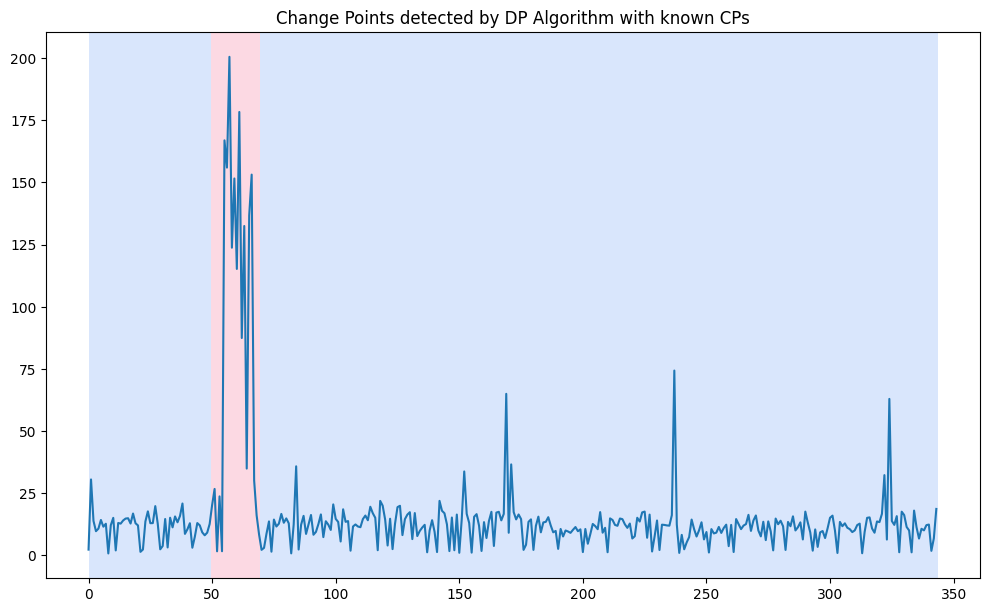

In [205]:
cpu_df["CPU Usage (%)"] = cpu_df["CPU Usage (%)"].astype(str).str.rstrip("%")

cpu_df["CPU Usage (%)"] = (cpu_df["CPU Usage (%)"].astype(str).str.rstrip("% ").astype("float"))

signal = cpu_df["CPU Usage (%)"].values

model = "rbf"  # "l1", "rbf" # Try with different models and compare results

algo = rpt.Dynp(model=model, min_size=1, jump=5).fit(signal)
result = algo.predict(n_bkps=2)

rpt.display(signal, result, figsize=(10, 6))
plt.title("Change Points detected by DP Algorithm with known CPs")
plt.show()

# Metric: Transaction counts (#) 

## Formatting

#### Extract log

In [2]:
log_file_path = "TRT/filtered_transaction_data.log"

log_file_path = "TRT/filtered_transaction_data.log"
output_file_path = "TC/transaction_counts.log"
match_term = "TRANSACTION COUNT"

with open(log_file_path, "r") as file:
    lines = file.readlines()

# Find the index of the line that matches the term
match_index = next((index for index, line in enumerate(lines) if match_term in line), None)

if match_index is not None:
    # Write the lines from the match index to the end of the file to the output file
    with open(output_file_path, "w") as output_file:
            
        output_file.writelines(lines[match_index:])
        
else:
    print("Match term not found in the log file.")

    

#### CSV

In [181]:
# Filter the log file to remove unnecessary lines
counter_pattern = r'"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})": "(\d+)",'

log_file = "TC/transaction_counts.log"
output_file_path = "TC/transaction_counts.csv"

with open(log_file, "r") as file, open(output_file_path, "w") as output_file:

    output_file.write("Timestamp,Transaction_Count\n")

    for line in file:
        if re.match(counter_pattern, line.strip()):
            line = line.replace('"', '')
            count_colon = 0
            count_comma = 0
            new_line = ''
            for i in range(len(line)):
                if line[i] == ':':
                    count_colon += 1
                    if count_colon % 3 == 0:
                        new_line += ','  
                    else:
                        new_line += line[i]
                elif line[i] == ',':
                    count_comma += 1
                    if count_comma % 2 != 0:
                        new_line += line[i]
                else:
                    new_line += line[i]
            new_line = new_line.replace(', ', ',')  
            output_file.write(new_line)

## Preprocessing

#### Transaction counts (#)

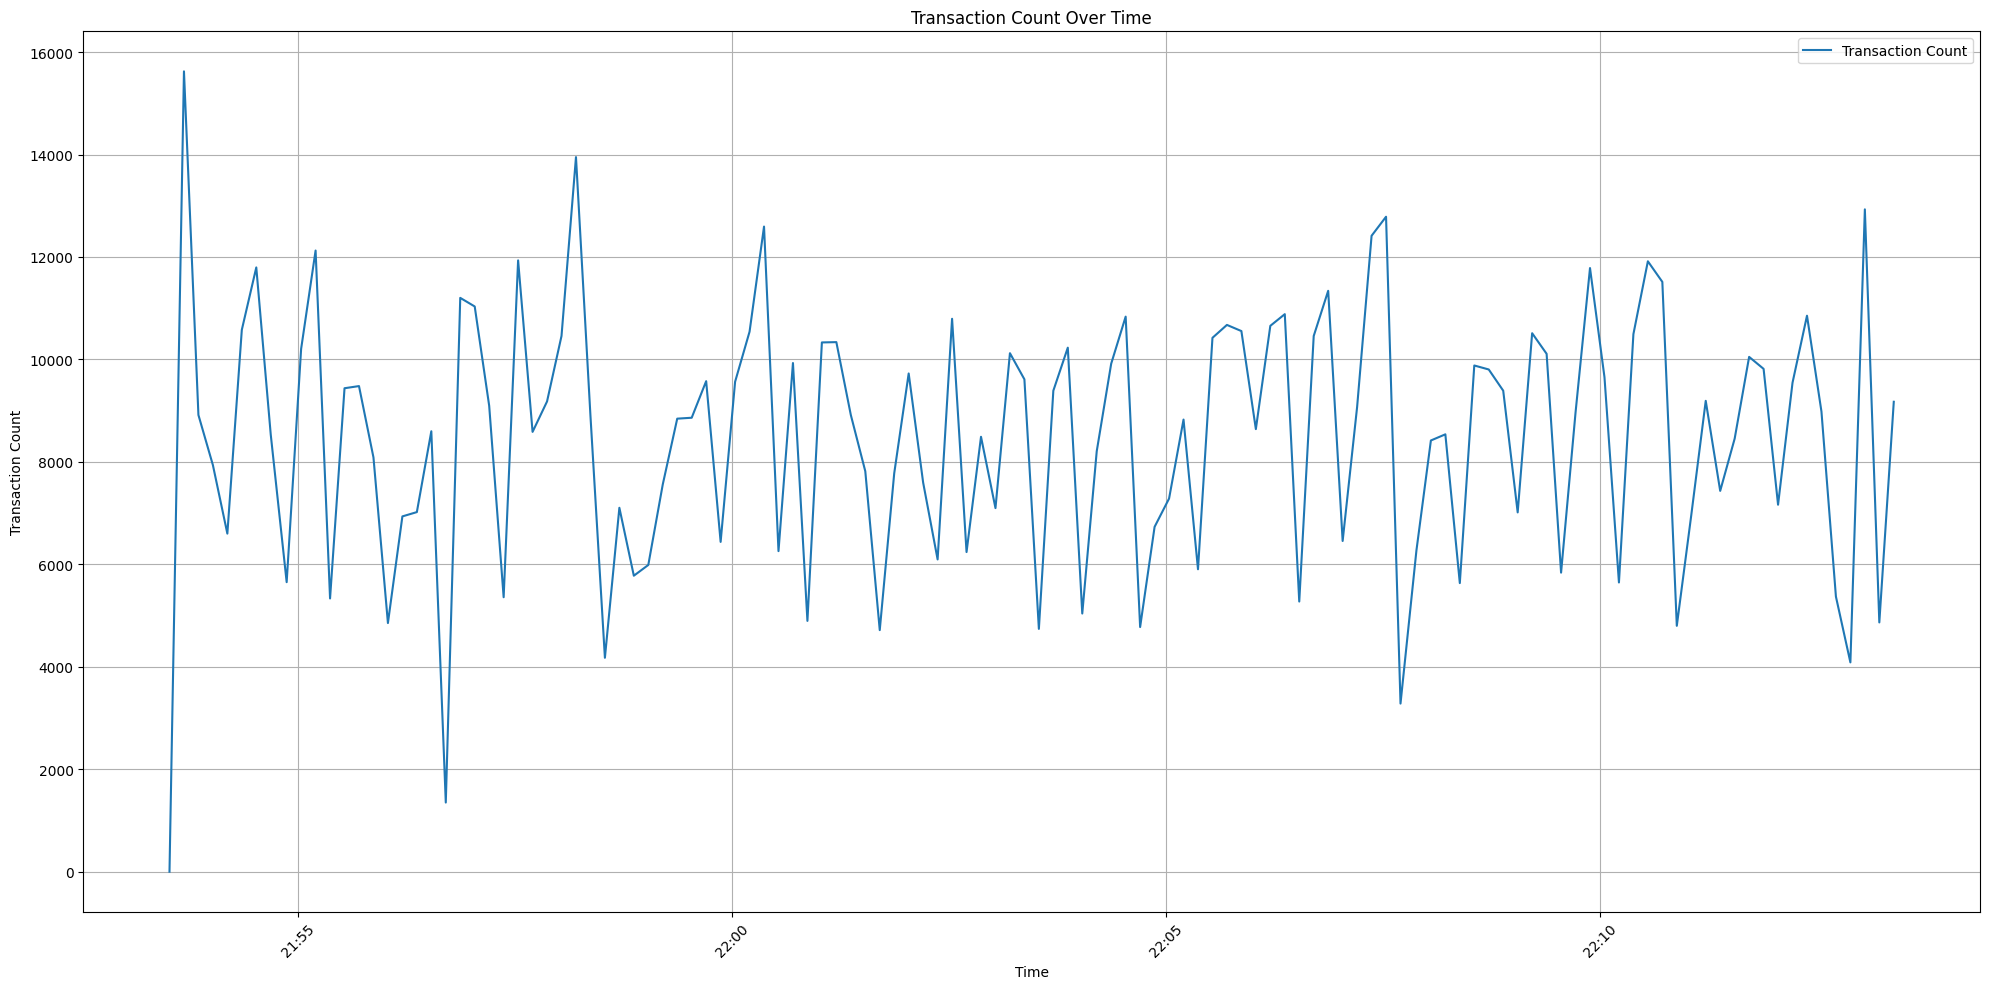

In [190]:
df = pd.read_csv("TC/transaction_counts.csv", usecols=[0, 1])
df.columns = df.columns.str.strip()
df["Timestamp"] = df["Timestamp"].str.strip()
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y-%m-%d %H:%M:%S")

#print(df.head(5))

plt.figure(figsize=(20, 10))

plt.plot(df['Timestamp'], df['Transaction_Count'], label="Transaction Count", linestyle="-")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

plt.xlabel("Time")

plt.ylabel("Transaction Count")

plt.title("Transaction Count Over Time")

plt.grid(True)

plt.tight_layout()  

plt.legend()

plt.show()

## CPD

#### Pelt

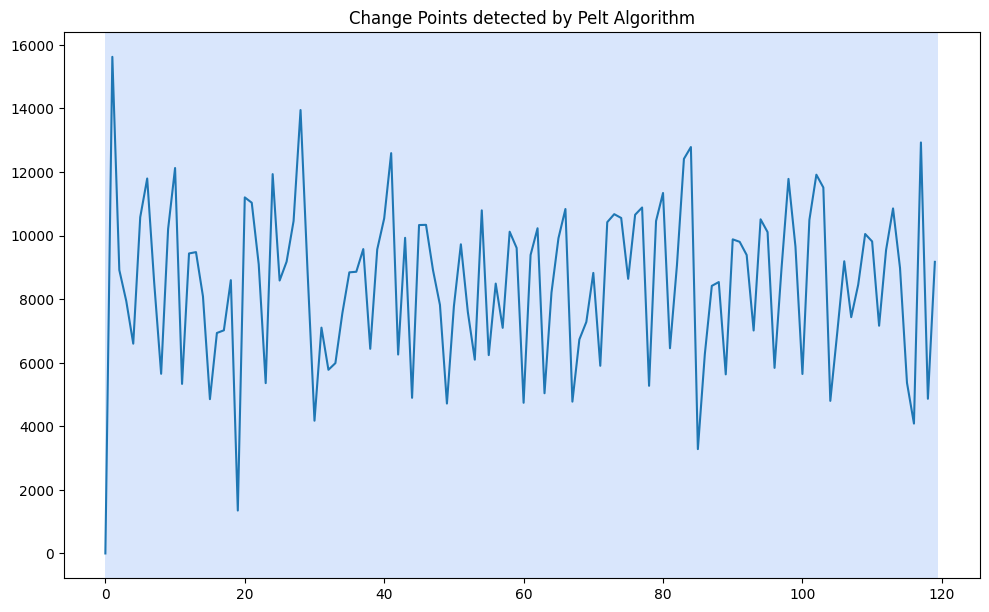

In [204]:

signal = df["Transaction_Count"].values

model = "rbf"  # "l1", "rbf" # Try with different models and compare results

algo = rpt.Pelt(model=model).fit(signal)

result = algo.predict(pen=200)

# Using ruptures display function
rpt.display(signal, result, figsize=(10, 6))
plt.title("Change Points detected by Pelt Algorithm")
plt.show()

#### DP

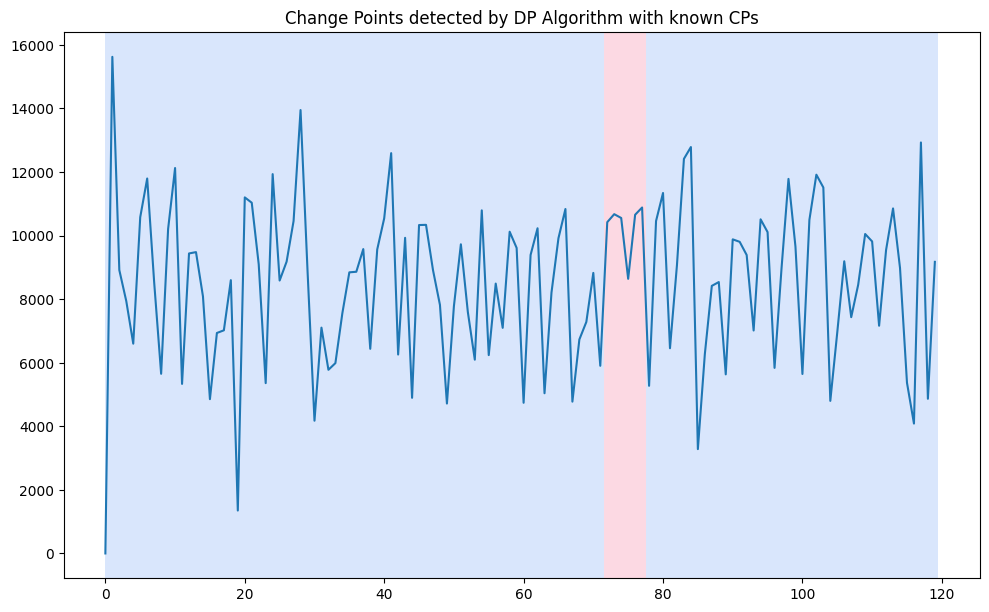

In [201]:
signal = df["Transaction_Count"].values

model = "rbf"  # "l1", "rbf" # Try with different models and compare results

algo = rpt.Dynp(model=model, min_size=3, jump=3).fit(signal)
result = algo.predict(n_bkps=2)

rpt.display(signal, result, figsize=(10, 6))
plt.title("Change Points detected by DP Algorithm with known CPs")
plt.show()